In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import numpy as np
import os
import gzip
import glob
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from time import time

In [2]:
from tensorflow.python.keras import models
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D,Dropout
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten,BatchNormalization
from tensorflow.python.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.datasets import mnist

In [3]:
tf.__version__

'1.12.0'

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x = np.concatenate((x_train,x_test))
y_class = np.concatenate((y_train,y_test))

In [6]:
num_classes = 10
img_size_flat = 28*28
img_shape_full = (28,28)
TotalSize = 70000

In [7]:
x_train, x_test, y_train_cls, y_test_cls = train_test_split(x.reshape(TotalSize,28,28,1), y_class, test_size=0.40, random_state=42)
train_size = y_train_cls.shape[0]
test_size = y_test_cls.shape[0]
print(train_size,test_size)

42000 28000


In [8]:
b = np.zeros((train_size, num_classes))
b[np.arange(train_size), y_train_cls] = 1
y_train = b

In [9]:
b = np.zeros((test_size, num_classes))
b[np.arange(test_size), y_test_cls] = 1
y_test = b

In [10]:
x_train[0].shape

(28, 28, 1)

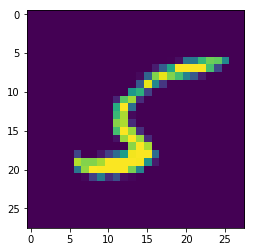

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [11]:
imgplot = plt.imshow(x_train[0].reshape(28,28))
plt.show()
print(y_train[5])

In [12]:
model = Sequential()

model.add(InputLayer(input_shape=(28,28,1,)))

model.add(Conv2D(kernel_size=7, strides=1, filters=32,
                 activation='relu', name='layer_conv1'))

model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=2, strides=2))


model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv1 (Conv2D)         (None, 22, 22, 32)        1600      
_________________________________________________________________
batch_normalization (BatchNo (None, 22, 22, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3965952   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 3,977,930
Trainable params: 3,977,866
Non-trainable params: 64
_________________________________________________________________

In [14]:
optimizer = Adam(lr=1e-4)

In [15]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# model.compile(optimizer=optimizer,
#               loss='binary_crossentropy',
#               metrics=['accuracy'])


In [16]:
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [17]:
model.fit(x=x_train,
          y=y_train,
          epochs=3, batch_size=128,verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[tensorboard])

Train on 42000 samples, validate on 28000 samples
Epoch 1/3
42000/42000 [==============================] - 21s 501us/step - loss: 0.1774 - acc: 0.9441 - val_loss: 0.0820 - val_acc: 0.9751
Epoch 2/3
42000/42000 [==============================] - 7s 167us/step - loss: 0.0464 - acc: 0.9863 - val_loss: 0.0611 - val_acc: 0.9819
Epoch 3/3
42000/42000 [==============================] - 7s 165us/step - loss: 0.0216 - acc: 0.9943 - val_loss: 0.0520 - val_acc: 0.9838


In [18]:
result = model.evaluate(x=x_test,
                        y=y_test)

28000/28000 [==============================] - 1s 48us/step


In [19]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.05199759496043303
acc 0.9838214285714286


In [20]:
model.save("Task1_P2.h5")

In [21]:
def print_confusion_matrix(cm):
    recall=[]
    precision=[]
    recall_val = 0
    for i in range(len(cm)):
        num = cm[i][i]
        row_sum=cm[i].sum()
        recall_val = (1.0*num/row_sum)
        recall.append(recall_val);
        precision_val = (1.0*cm[i][i]/cm[:,i].sum())
        precision.append(precision_val)
    f = []
    f.append(np.array(recall))
    f.append(np.array(precision))
    f_score=[]
    for i in range(len(recall)):
        val = 2.0 * recall[i] * precision[i]
        val /= (precision[i]+recall[i])
        f_score.append(val)
    f.append(np.array(f_score))
    print(np.array(f))
    plt.figure(figsize=(6,6), dpi=200)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    plt.savefig('3.png')

In [22]:
# Predicting the Test set results
y_pred = model.predict(x_test)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

[[0.98272138 0.99018677 0.9828938  0.98161895 0.98602719 0.98191824
  0.99313087 0.98760469 0.97335835 0.97730496]
 [0.99236641 0.99364676 0.9787083  0.97678509 0.98677249 0.98076168
  0.9881295  0.98103161 0.98183195 0.97730496]
 [0.98752035 0.99191375 0.98079659 0.97919605 0.9863997  0.98133962
  0.99062387 0.98430718 0.97757679 0.97730496]]


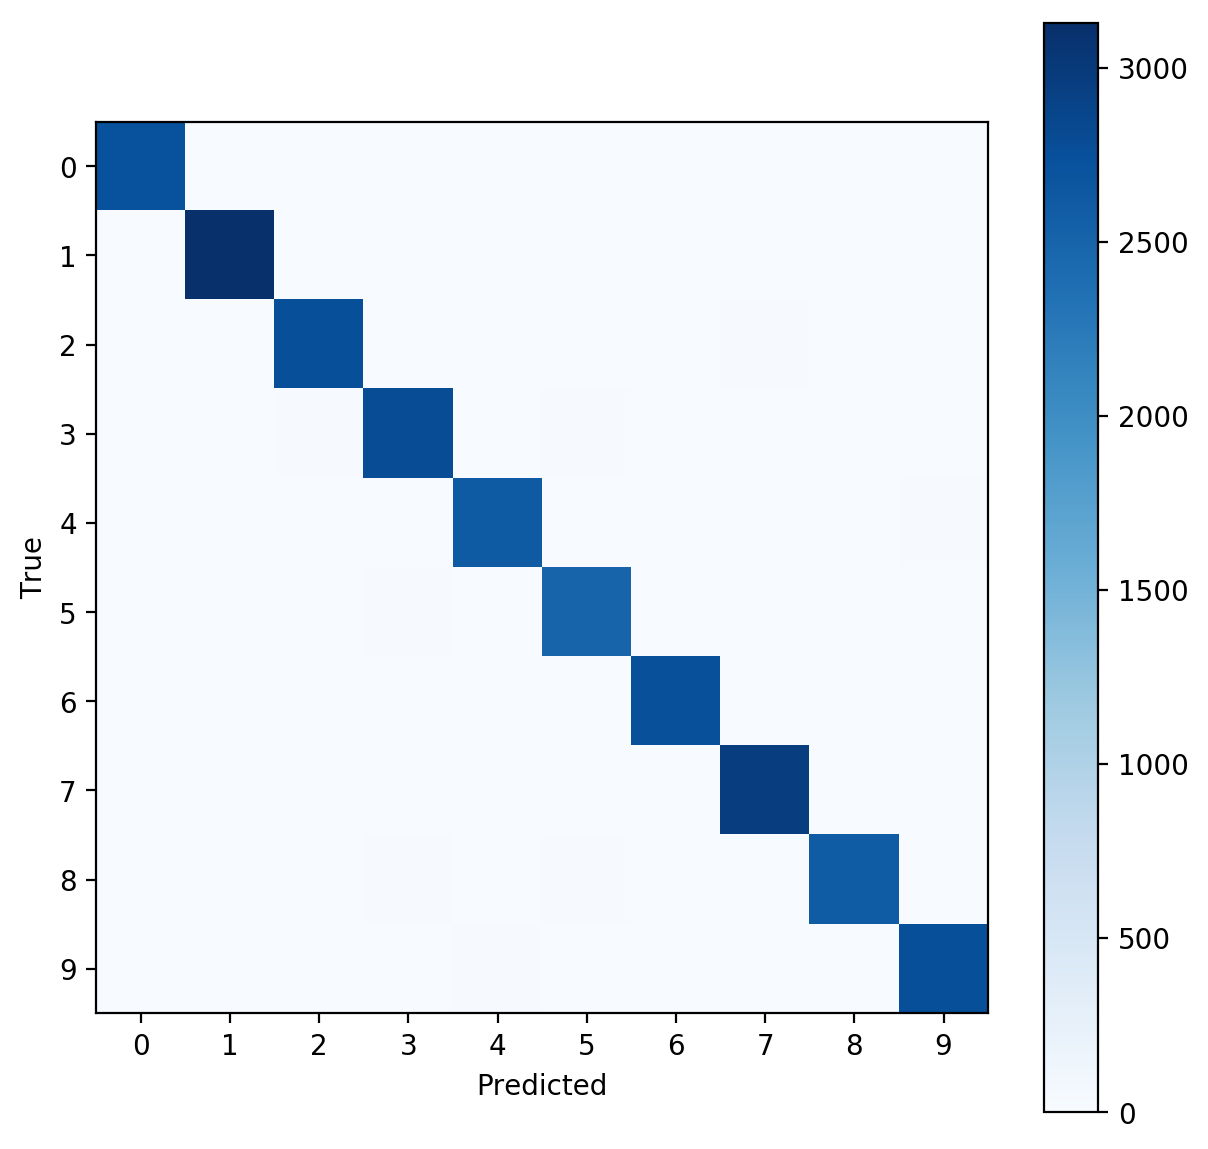

<Figure size 432x288 with 0 Axes>

In [23]:
print_confusion_matrix(cm)